<a href="https://colab.research.google.com/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Identification_Arbres/Id_arbre-reseau_convolutif-transfert-colab.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rappel - Fonctionnement d'un carnet web iPython

* Pour exécuter le code contenu dans une cellule d'un carnet iPython, cliquez dans la cellule et faites (⇧↵, shift-enter) 
* Le code d'un carnet iPython s'exécute séquentiellement de haut en bas de la page. Souvent, l'importation d'une bibliothèque Python ou l'initialisation d'une variable est préalable à l'exécution d'une cellule située plus bas. Il est donc recommandé d'exécuter les cellules en séquence. Enfin, méfiez-vous des retours en arrière qui peuvent réinitialiser certaines variables.

# Identification d'arbres à partir de leur écorce
## Réseau convolutif et apprentissage par transfert

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Apprentissage par transfert et paufinage

## Fixer le hasard pour la reproductibilité

La mise au point de réseaux de neurones implique certains processus aléatoires. Afin de pouvoir reproduire et comparer vos résultats d'expérience, vous fixez temporairement l'état aléatoire grâce à un germe aléatoire unique.

Pendant la mise au point, vous fixez temporairement l'état aléatoire pour la reproductibilité mais vous répétez l'expérience avec différents germes ou états aléatoires et prenez la moyenne des résultats.
<br/>
**Note** : Pour un système en production, vous ravivez simplement l'état  purement aléatoire avec l'instruction `GERME_ALEATOIRE = None`

In [2]:
import os

# Définir un germe aléatoire
GERME_ALEATOIRE = 1

# Définir un état aléatoire pour Python
os.environ['PYTHONHASHSEED'] = str(GERME_ALEATOIRE)

# Définir un état aléatoire pour Python random
import random
random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour NumPy
import numpy as np
np.random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour TensorFlow
import tensorflow as tf
tf.random.set_seed(GERME_ALEATOIRE)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

print("Germe aléatoire fixé")

Germe aléatoire fixé


## Acquisition des donnés

In [3]:
import os

In [4]:
# Note that we did not use Acer platanoides (2), Pinus rigida (15) and Populus grandidentata (18)
# since we did not collect enough images in these categories to obtain meaningful results.
data_ecorces = {
    'SAB': 1,  
#    'ERB': 2,  # Pas assez de spécimens - seulement 1
    'ERR': 3, 
    'ERS': 4, 
    'BOJ': 5, 
    'BOP': 6,
    'HEG': 7,  
    'FRA': 8, 
    'MEL': 9,  
    'OSV': 10, 
    'EPO': 11,
    'EPB': 12,
    'EPN': 13,
    'EPR': 14,
#    'PID': 15, # Pas assez de spécimens - seulement 4
    'PIR': 16, 
    'PIB': 17, 
#    'PEG': 18, # Pas assez de spécimens - seulement 3
    'PET': 19, 
    'CHR': 20,
    'THO': 21, 
    'PRU': 22, 
    'ORA': 23  
}

noms_arbres = {
            1: '\emph{Abies balsamea} - Sapin Baumier - Balsam fir',
            2: '\emph{Acer platanoides} - Érable de Norvège - Norway maple',
            3: '\emph{Acer rubrum} - Érable rouge - Red maple',
            4: '\emph{Acer saccharum} - Érable à sucre - Sugar maple',
            5: '\emph{Betula alleghaniensis} - Bouleau jaune - Yellow birch',
            6: '\emph{Betula papyrifera} - Bouleau à papier - White birch',
            7: '\emph{Fagus grandifolia} - Hêtre à grandes feuilles - American beech',
            8: "\emph{Fraxinus americana} - Frêne d'Amérique - White ash",
            9: '\emph{Larix laricina} - Mélèze - Tamarack',
            10: '\emph{Ostrya virginiana} - Ostryer de Virginie - American hophornbeam',
            11: '\emph{Picea abies} - Épinette de Norvège - Norway spruce',
            12: '\emph{Picea glauca} - Épinette blanche - White spruce',
            13: '\emph{Picea mariana} - Épinette noire - Black spruce',
            14: '\emph{Picea rubens} - Épinette rouge - Red spruce',
            15: '\emph{Pinus rigida} - Pin rigide - Pitch pine',
            16: '\emph{Pinus resinosa} - Pin rouge - Red pine',
            17: '\emph{Pinus strobus} - Pin blanc - Eastern white pine',
            18: '\emph{Populus grandidentata} - Peuplier à grandes dents - Big-tooth aspen',
            19: '\emph{Populus tremuloides} - Peuplier faux tremble - Quaking aspen',
            20: '\emph{Quercus rubra} - Chêne rouge - Northern red oak',
            21: '\emph{Thuja occidentalis} - Thuya occidental - Northern white cedar',
            22: '\emph{Tsuga canadensis} - Pruche du Canada - Eastern Hemlock',
            23: "\emph{Ulmus americana} - Orme d'Amérique - American elm"
        }

dict_no_arbres_ID = {
    '1':'SAB',  
    '2':'ERB',
    '3':'ERR', 
    '4':'ERS', 
    '5':'BOJ', 
    '6':'BOP',
    '7':'HEG',  
    '8':'FRA', 
    '9':'MEL',  
    '10':'OSV', 
    '11':'EPO',
    '12':'EPB',
    '13':'EPN',
    '14':'EPR',
    '15':'PID',
    '16':'PIR', 
    '17':'PIB',
    '18':'PEG',
    '19':'PET', 
    '20':'CHR',
    '21':'THO', 
    '22':'PRU', 
    '23':'ORA'  
}

print("Code exécuté")

Code exécuté


In [5]:
data_zip_urls_dict = {
   "BOJ":"https://drive.google.com/file/d/1d2zxg2pt5S8UJIK-E7IuWfGN0d1kxxMw/view?usp=sharing",
   "BOP":"https://drive.google.com/file/d/12cg6UO4HLnjk5fE_KXtrgdC2s8uGh4Zp/view?usp=sharing",
   "CHR":"https://drive.google.com/file/d/1Nq19-I-Q577KXMTFrkhlJDhMfclh0cWn/view?usp=sharing",
   "EPB":"https://drive.google.com/file/d/1K_Ncw8VEiuDZ_iJDbYToMq-GO5dzKHns/view?usp=sharing",
   "EPN":"https://drive.google.com/file/d/1S309DYmg76SrIA89aVQWXCMwm6CzhN8b/view?usp=sharing",
   "EPO":"https://drive.google.com/file/d/1fTKEcpYgmRg4spUpcH0FAiAnoRgANafL/view?usp=sharing",
   "EPR":"https://drive.google.com/file/d/1qRhtZ8LZjH_45fxetG7swg3ok3znk8CJ/view?usp=sharing",
#   "ERB":"https://drive.google.com/file/d/1ighbGniKAT_GrPm4RtsIAuN1STg9sjR9/view?usp=sharing", # Assez de données?
   "ERR":"https://drive.google.com/file/d/1rEo1thMNJTgFeTzTOfI11_FPSqMgbHSL/view?usp=sharing",
   "ERS":"https://drive.google.com/file/d/1ts-t7bOH9DfKj0q0v35nMgKHgVT0ZjyG/view?usp=sharing",
   "FRA":"https://drive.google.com/file/d/1yLacRGW7JtlFWV5asEXHpAToClL38D64/view?usp=sharing",
   "HEG":"https://drive.google.com/file/d/1zoJKEIrsCD1XxglgPJkEygumev1xRQ3U/view?usp=sharing",
   "MEL":"https://drive.google.com/file/d/1Wdy3DDnWfUysXjcIFFq12UFW7tlTYDT2/view?usp=sharing",
   "ORA":"https://drive.google.com/file/d/19_oYwCAaPfP6vMuqUnAzIQAa39Brxhfi/view?usp=sharing",
   "OSV":"https://drive.google.com/file/d/1VJCCZN1iwBK2Nzh_PHC9xvw63xiLuXXI/view?usp=sharing",
#   "PEG":"https://drive.google.com/file/d/1YUWH4IaTnmcoIAavZq8HyXByJxO7_zBg/view?usp=sharing", # Assez de données?
   "PET":"https://drive.google.com/file/d/13bMkvr_1mRz1TuOcX8-c-LfTSIsNKrve/view?usp=sharing",
   "PIB":"https://drive.google.com/file/d/17J9g1xm6-ji52k2pgJr7mUrJdS1ASSqP/view?usp=sharing",
#   "PID":"https://drive.google.com/file/d/12xswrf4pDmTAcYZDAY9D-0HniLjGJCxp/view?usp=sharing", # Assez de données?
   "PIR":"https://drive.google.com/file/d/1qny4meuoT-HYZ_KTyPQbQnzLhebkgkfU/view?usp=sharing",
   "PRU":"https://drive.google.com/file/d/1xQWHQvIbwRRBoi2F27q22_drUeM8m3S8/view?usp=sharing",
   "SAB":"https://drive.google.com/file/d/1ol2mlYAz5bMfQkwqcnxhCOg4avftYtRe/view?usp=sharing",
   "THO":"https://drive.google.com/file/d/1_mI0saGpfxb4wnhElCzxg0WU4OiFHkfP/view?usp=sharing",
  
}
data_zip_urls_dict

{'BOJ': 'https://drive.google.com/file/d/1d2zxg2pt5S8UJIK-E7IuWfGN0d1kxxMw/view?usp=sharing',
 'BOP': 'https://drive.google.com/file/d/12cg6UO4HLnjk5fE_KXtrgdC2s8uGh4Zp/view?usp=sharing',
 'CHR': 'https://drive.google.com/file/d/1Nq19-I-Q577KXMTFrkhlJDhMfclh0cWn/view?usp=sharing',
 'EPB': 'https://drive.google.com/file/d/1K_Ncw8VEiuDZ_iJDbYToMq-GO5dzKHns/view?usp=sharing',
 'EPN': 'https://drive.google.com/file/d/1S309DYmg76SrIA89aVQWXCMwm6CzhN8b/view?usp=sharing',
 'EPO': 'https://drive.google.com/file/d/1fTKEcpYgmRg4spUpcH0FAiAnoRgANafL/view?usp=sharing',
 'EPR': 'https://drive.google.com/file/d/1qRhtZ8LZjH_45fxetG7swg3ok3znk8CJ/view?usp=sharing',
 'ERR': 'https://drive.google.com/file/d/1rEo1thMNJTgFeTzTOfI11_FPSqMgbHSL/view?usp=sharing',
 'ERS': 'https://drive.google.com/file/d/1ts-t7bOH9DfKj0q0v35nMgKHgVT0ZjyG/view?usp=sharing',
 'FRA': 'https://drive.google.com/file/d/1yLacRGW7JtlFWV5asEXHpAToClL38D64/view?usp=sharing',
 'HEG': 'https://drive.google.com/file/d/1zoJKEIrsCD1XxglgPJ

In [6]:
# Création des répertoires de données
# Nous allons créer un répertoire de base `src` et des répertoiresnpour les données 
# d'entrainement, de validation et de test pour chaque étiquette cible

try:
    os.mkdir("/content/src/")
except OSError:
    pass
try:
    os.mkdir("/content/lab_id_arbres/")
except OSError:
    pass


In [7]:
# Référence: https://colab.research.google.com/notebooks/io.ipynb
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import shutil
import zipfile


In [9]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [10]:
nbr_classes = 0
for arbre_id in data_zip_urls_dict.keys():
    url = data_zip_urls_dict[arbre_id]
    id_fichier = url.split('/')[5]
    fichier = drive.CreateFile({'id':id_fichier})
    nom_fichier = arbre_id + ".zip"
    # télécharger le fichier nom_fichier
    fichier.GetContentFile("/content/src/" + nom_fichier)
    print("Fichier " + nom_fichier + " téléchargé")
    zip_ref = zipfile.ZipFile("/content/src/" + nom_fichier, 'r')
    zip_ref.extractall("/content/src")
    zip_ref.close()
    print("Fichier " + nom_fichier + " décompressé")
    try:
        os.remove("/content/src/"+nom_fichier)
        print("Fichier " + nom_fichier + " effacé")
    except:
        print("?")
    nbr_classes += 1
shutil.rmtree('/content/src/__MACOSX')
print("nbr_classes:",nbr_classes)

Fichier BOJ.zip téléchargé
Fichier BOJ.zip décompressé
Fichier BOJ.zip effacé
Fichier BOP.zip téléchargé
Fichier BOP.zip décompressé
Fichier BOP.zip effacé
Fichier CHR.zip téléchargé
Fichier CHR.zip décompressé
Fichier CHR.zip effacé
Fichier EPB.zip téléchargé
Fichier EPB.zip décompressé
Fichier EPB.zip effacé
Fichier EPN.zip téléchargé
Fichier EPN.zip décompressé
Fichier EPN.zip effacé
Fichier EPO.zip téléchargé
Fichier EPO.zip décompressé
Fichier EPO.zip effacé
Fichier EPR.zip téléchargé
Fichier EPR.zip décompressé
Fichier EPR.zip effacé
Fichier ERR.zip téléchargé
Fichier ERR.zip décompressé
Fichier ERR.zip effacé
Fichier ERS.zip téléchargé
Fichier ERS.zip décompressé
Fichier ERS.zip effacé
Fichier FRA.zip téléchargé
Fichier FRA.zip décompressé
Fichier FRA.zip effacé
Fichier HEG.zip téléchargé
Fichier HEG.zip décompressé
Fichier HEG.zip effacé
Fichier MEL.zip téléchargé
Fichier MEL.zip décompressé
Fichier MEL.zip effacé
Fichier ORA.zip téléchargé
Fichier ORA.zip décompressé
Fichier O

## Répartition des données

In [11]:
!pip3 install split-folders tqdm

In [12]:
# Répartition des données d'entraînement, de validation et de tests
import splitfolders
import pathlib

#### input dataset that want to split
input_folder = "/content/src"
output_folder= "/content/lab_id_arbres"
# => train, val, test

image_count = len(list(pathlib.Path(input_folder).glob('*/*.jpg')))
print("Nombre total d'images:",image_count)

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio = (0.80, 0.15, 0.05))

print("\nRépartition des données terminée!")

Nombre total d'images: 3981


Copying files: 3981 files [00:06, 658.28 files/s]


Répartition des données terminée!


### Visualisation d'un échantillon des données

__________________________________________________________________________________________
SAB  Sapin Baumier 
/content/lab_id_arbres/train/SAB/993_SAB_87_GalaxyS5_20170622_091946_15.jpg
/content/lab_id_arbres/train/SAB/999_SAB_76_GalaxyS5_20170622_102352_2.jpg
/content/lab_id_arbres/train/SAB/983_SAB_59_GalaxyS5_20170615_133942_5.jpg
/content/lab_id_arbres/train/SAB/426_SAB_94_Nexus 5_20170615_135833_12.jpg


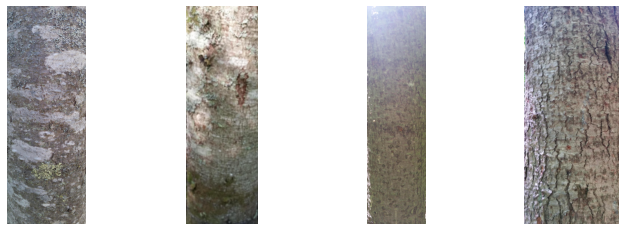

__________________________________________________________________________________________
ERR  Érable rouge 
/content/lab_id_arbres/train/ERR/563_ERR_74_GalaxyS7_20170922_131614_12.jpg
/content/lab_id_arbres/train/ERR/199_ERR_71_Nexus 5_20170804_111604_5.jpg
/content/lab_id_arbres/train/ERR/551_ERR_71_GalaxyS7_20170922_124512_17.jpg
/content/lab_id_arbres/train/ERR/761_ERR_95_GalaxyS5_20170615_111207_7.jpg


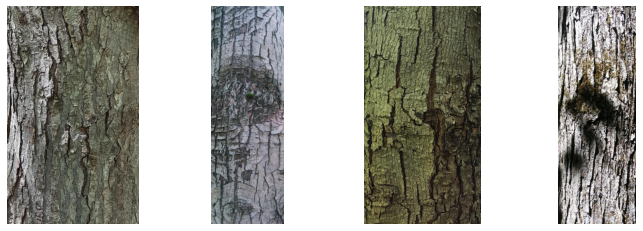

__________________________________________________________________________________________
ERS  Érable à sucre 
/content/lab_id_arbres/train/ERS/597_ERS_150_GalaxyS7_20170607_150335_42.jpg
/content/lab_id_arbres/train/ERS/210_ERS_97_Nexus 5_20170608_090726_4.jpg
/content/lab_id_arbres/train/ERS/779_ERS_50_GalaxyS5_20170713_103606_17.jpg
/content/lab_id_arbres/train/ERS/212_ERS_86_Nexus 5_20170608_091028_16.jpg


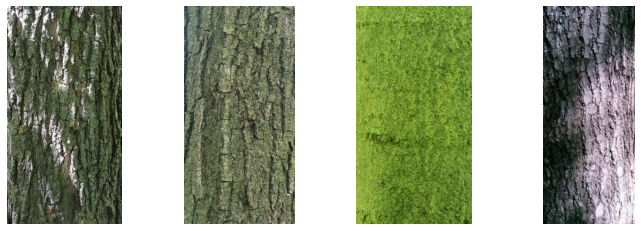

__________________________________________________________________________________________
BOJ  Bouleau jaune 
/content/lab_id_arbres/train/BOJ/656_BOJ_47_GalaxyS5_20170622_105850_9.jpg
/content/lab_id_arbres/train/BOJ/658_BOJ_36_GalaxyS5_20170622_113427_8.jpg
/content/lab_id_arbres/train/BOJ/654_BOJ_40_GalaxyS5_20170622_103118_3.jpg
/content/lab_id_arbres/train/BOJ/649_BOJ_84_GalaxyS5_20170615_134155_13.jpg


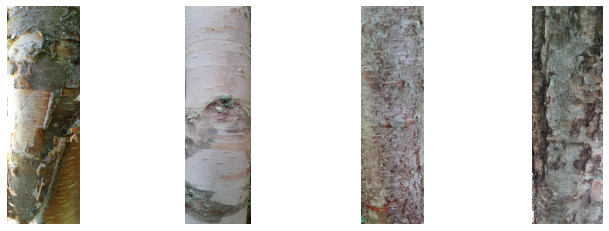

__________________________________________________________________________________________
BOP  Bouleau à papier 
/content/lab_id_arbres/train/BOP/670_BOP_51_GalaxyS5_20170713_101145_4.jpg
/content/lab_id_arbres/train/BOP/40_BOP_62_Nexus 5_20170906_110024_7.jpg
/content/lab_id_arbres/train/BOP/672_BOP_60_GalaxyS5_20170713_115823_13.jpg
/content/lab_id_arbres/train/BOP/33_BOP_89_Nexus 5_20170608_091516_19.jpg


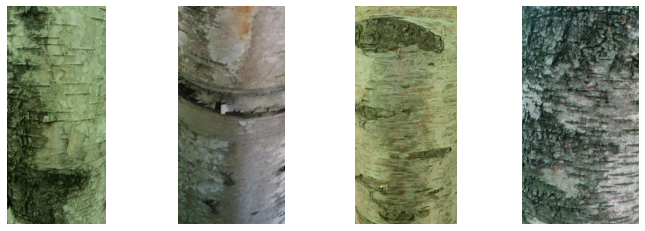

__________________________________________________________________________________________
HEG  Hêtre à grandes feuilles 
/content/lab_id_arbres/train/HEG/802_HEG_56_GalaxyS5_20170713_111609_3.jpg
/content/lab_id_arbres/train/HEG/622_HEG_81_GalaxyS7_20170916_175841_20.jpg
/content/lab_id_arbres/train/HEG/285_HEG_90_Nexus 5_20170906_103913_11.jpg
/content/lab_id_arbres/train/HEG/280_HEG_75_Nexus 5_20170804_092952_4.jpg


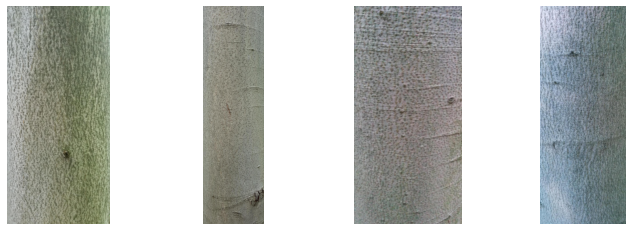

__________________________________________________________________________________________
FRA  Frêne d'Amérique 
/content/lab_id_arbres/train/FRA/263_FRA_87_Nexus 5_20170804_103129_2.jpg
/content/lab_id_arbres/train/FRA/255_FRA_114_Nexus 5_20170804_101859_6.jpg
/content/lab_id_arbres/train/FRA/250_FRA_144_Nexus 5_20170804_100422_6.jpg
/content/lab_id_arbres/train/FRA/269_FRA_55_Nexus 5_20170804_110414_8.jpg


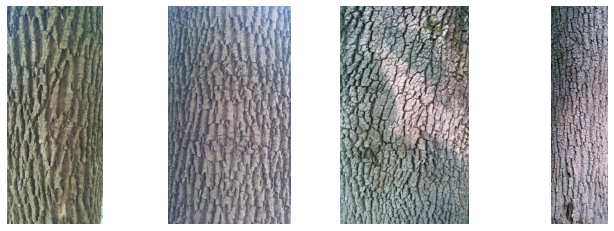

__________________________________________________________________________________________
MEL  Mélèze 
/content/lab_id_arbres/train/MEL/824_MEL_102_GalaxyS5_20170706_104204_7.jpg
/content/lab_id_arbres/train/MEL/855_MEL_93_GalaxyS5_20170706_114214_24.jpg
/content/lab_id_arbres/train/MEL/826_MEL_99_GalaxyS5_20170706_104529_10.jpg
/content/lab_id_arbres/train/MEL/861_MEL_90_GalaxyS5_20170706_115456_9.jpg


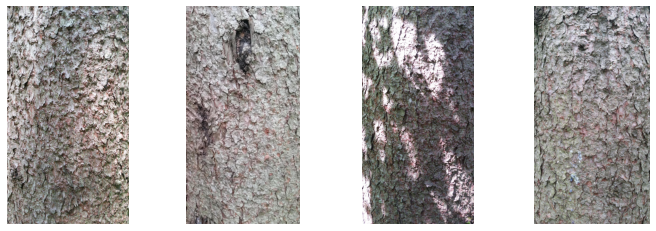

__________________________________________________________________________________________
OSV  Ostryer de Virginie 
/content/lab_id_arbres/train/OSV/886_OSV_80_GalaxyS5_20170713_104000_9.jpg
/content/lab_id_arbres/train/OSV/890_OSV_190_GalaxyS5_20170713_105525_5.jpg
/content/lab_id_arbres/train/OSV/307_OSV_64_Nexus 5_20170906_103508_19.jpg
/content/lab_id_arbres/train/OSV/312_OSV_46_Nexus 5_20170906_105146_3.jpg


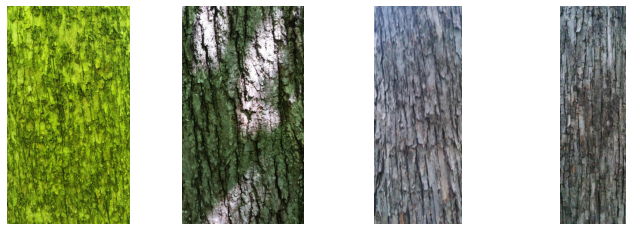

__________________________________________________________________________________________
EPO  Épinette de Norvège 
/content/lab_id_arbres/train/EPO/135_EPO_114_Nexus 5_20170921_152635_8.jpg
/content/lab_id_arbres/train/EPO/126_EPO_102_Nexus 5_20170921_151608_8.jpg
/content/lab_id_arbres/train/EPO/115_EPO_94_Nexus 5_20170817_120952_13.jpg
/content/lab_id_arbres/train/EPO/119_EPO_105_Nexus 5_20170817_121237_16.jpg


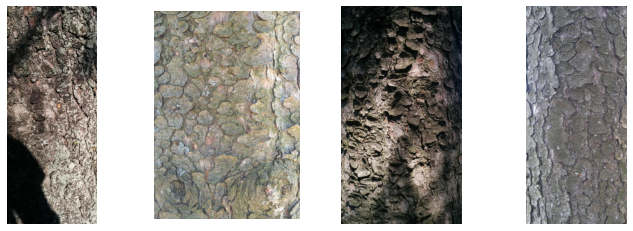

__________________________________________________________________________________________
EPB  Épinette blanche 
/content/lab_id_arbres/train/EPB/90_EPB_73_Nexus 5_20170817_111119_15.jpg
/content/lab_id_arbres/train/EPB/107_EPB_82_Nexus 5_20170817_113309_9.jpg
/content/lab_id_arbres/train/EPB/89_EPB_71_Nexus 5_20170817_111001_8.jpg
/content/lab_id_arbres/train/EPB/83_EPB_110_Nexus 5_20170817_110019_13.jpg


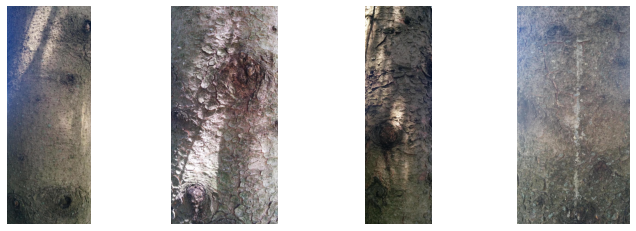

__________________________________________________________________________________________
EPN  Épinette noire 
/content/lab_id_arbres/train/EPN/703_EPN_70_GalaxyS5_20170622_101740_10.jpg
/content/lab_id_arbres/train/EPN/735_EPN_63_GalaxyS5_20170622_115059_21.jpg
/content/lab_id_arbres/train/EPN/721_EPN_83_GalaxyS5_20170622_110803_16.jpg
/content/lab_id_arbres/train/EPN/723_EPN_73_GalaxyS5_20170622_111138_5.jpg


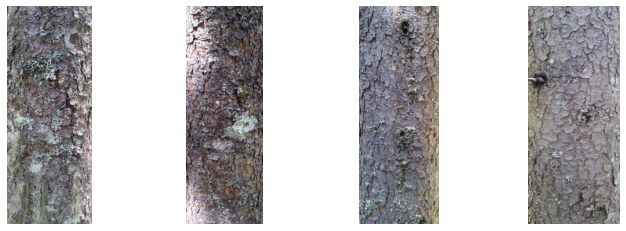

__________________________________________________________________________________________
EPR  Épinette rouge 
/content/lab_id_arbres/train/EPR/178_EPR_100_Nexus 5_20170608_102414_17.jpg
/content/lab_id_arbres/train/EPR/183_EPR_87_Nexus 5_20170608_102904_20.jpg
/content/lab_id_arbres/train/EPR/539_EPR_83_GalaxyS5_20170607_153802_8.jpg
/content/lab_id_arbres/train/EPR/189_EPR_121_Nexus 5_20170615_135955_9.jpg


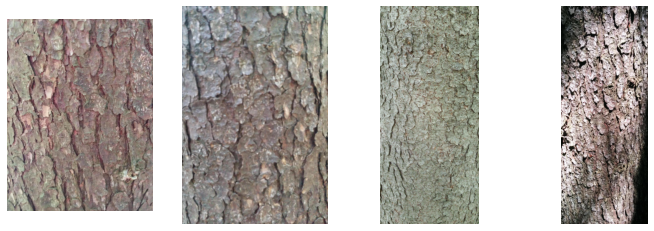

__________________________________________________________________________________________
PIR  Pin rouge 
/content/lab_id_arbres/train/PIR/355_PIR_120_Nexus 5_20170817_101049_2.jpg
/content/lab_id_arbres/train/PIR/352_PIR_97_Nexus 5_20170817_100053_14.jpg
/content/lab_id_arbres/train/PIR/362_PIR_97_Nexus 5_20170817_112057_14.jpg
/content/lab_id_arbres/train/PIR/350_PIR_96_Nexus 5_20170817_095801_3.jpg


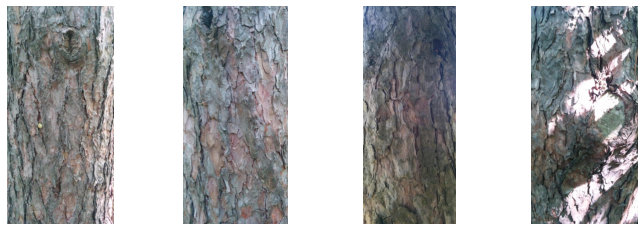

__________________________________________________________________________________________
PIB  Pin blanc 
/content/lab_id_arbres/train/PIB/336_PIB_95_Nexus 5_20170615_132131_6.jpg
/content/lab_id_arbres/train/PIB/971_PIB_88_GalaxyS5_20170713_101614_20.jpg
/content/lab_id_arbres/train/PIB/323_PIB_130_Nexus 5_20170615_124026_28.jpg
/content/lab_id_arbres/train/PIB/332_PIB_63_Nexus 5_20170615_125745_4.jpg


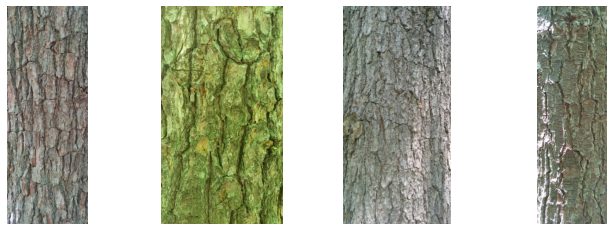

__________________________________________________________________________________________
PET  Peuplier faux tremble 
/content/lab_id_arbres/train/PET/951_PET_78_GalaxyS5_20170712_114356_6.jpg
/content/lab_id_arbres/train/PET/940_PET_63_GalaxyS5_20170712_112455_11.jpg
/content/lab_id_arbres/train/PET/935_PET_80_GalaxyS5_20170712_111735_2.jpg
/content/lab_id_arbres/train/PET/914_PET_113_GalaxyS5_20170712_103401_16.jpg


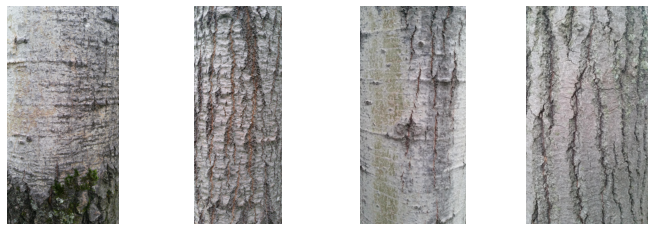

__________________________________________________________________________________________
CHR  Chêne rouge 
/content/lab_id_arbres/train/CHR/674_CHR_162_GalaxyS5_20170615_103841_4.jpg
/content/lab_id_arbres/train/CHR/52_CHR_82_Nexus 5_20170906_092540_2.jpg
/content/lab_id_arbres/train/CHR/79_CHR_127_Nexus 5_20170906_101333_9.jpg
/content/lab_id_arbres/train/CHR/51_CHR_95_Nexus 5_20170906_092429_7.jpg


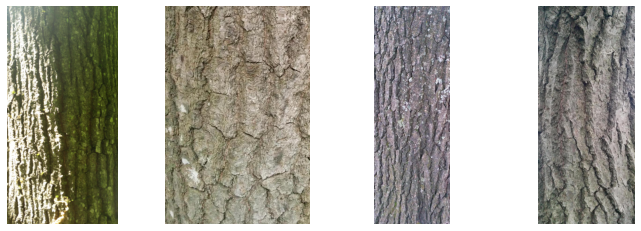

__________________________________________________________________________________________
THO  Thuya occidental 
/content/lab_id_arbres/train/THO/451_THO_67_Nexus 5_20170810_103638_4.jpg
/content/lab_id_arbres/train/THO/430_THO_74_Nexus 5_20170615_134333_18.jpg
/content/lab_id_arbres/train/THO/433_THO_66_Nexus 5_20170810_101058_2.jpg
/content/lab_id_arbres/train/THO/456_THO_119_Nexus 5_20170810_104123_10.jpg


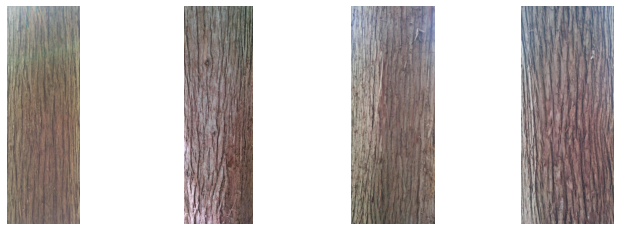

__________________________________________________________________________________________
PRU  Pruche du Canada 
/content/lab_id_arbres/train/PRU/395_PRU_72_Nexus 5_20170906_091528_8.jpg
/content/lab_id_arbres/train/PRU/407_PRU_131_Nexus 5_20170906_093125_10.jpg
/content/lab_id_arbres/train/PRU/396_PRU_89_Nexus 5_20170906_091635_4.jpg
/content/lab_id_arbres/train/PRU/975_PRU_70_GalaxyS5_20170713_110707_8.jpg


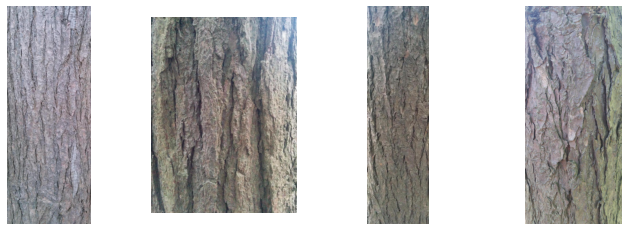

__________________________________________________________________________________________
ORA  Orme d'Amérique 
/content/lab_id_arbres/train/ORA/290_ORA_122_Nexus 5_20170810_105157_9.jpg
/content/lab_id_arbres/train/ORA/291_ORA_69_Nexus 5_20170810_105335_7.jpg
/content/lab_id_arbres/train/ORA/293_ORA_110_Nexus 5_20170810_105638_2.jpg
/content/lab_id_arbres/train/ORA/295_ORA_76_Nexus 5_20170810_111759_6.jpg


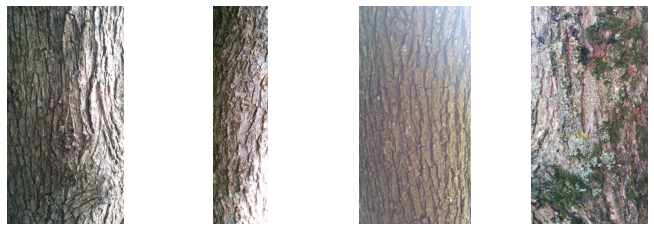

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 4

TRAINING_DIR = "/content/lab_id_arbres/train/"

for arbre_id in data_ecorces.keys():
    try:
        dir_path = os.path.join(TRAINING_DIR,arbre_id+os.sep)
        liste_fichiers = os.listdir(os.path.join(TRAINING_DIR,arbre_id+os.sep))
        next_two_pics = [os.path.join(dir_path, fname) for fname in liste_fichiers[0:pic_index]]
        fig = plt.figure(figsize=(12,4))
        print("_"*90)
        print(arbre_id,noms_arbres[data_ecorces[arbre_id]].split('-')[1])
        for i, img_path in enumerate(next_two_pics):
            print(img_path)
            img = mpimg.imread(img_path)
            plt.subplot(1,pic_index,i+1)
            plt.imshow(img)
            plt.axis('Off')
        plt.show()
    except:
        continue

### Création de flux de lots de données pour l'entraînement

Chargeons ces images en mémoire en créant des `tf.data.dataset` à l'aide de l'utilitaire `tf.keras.utils.image_dataset_from_directory`. 

tf.data.Dataset prend en charge l'écriture de chaîne de traitement d'entrée de données efficaces. L'itération se produit dans un flux continu, de sorte que l'ensemble de données complet n'a pas besoin de tenir dans la mémoire.

In [14]:
import os

import keras
print("Keras version:",keras.__version__)
import tensorflow as tf
print("TensorFlow version:",tf.__version__)

Keras version: 2.7.0
TensorFlow version: 2.7.0


In [15]:
TRAINING_DIR = "/content/lab_id_arbres/train/"
VALIDATION_DIR = "/content/lab_id_arbres/val"
TESTING_DIR = "/content/lab_id_arbres/test/"

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_dataset = tf.keras.utils.image_dataset_from_directory(TRAINING_DIR,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 3175 files belonging to 20 classes.


In [16]:
id_classes = train_dataset.class_names
print(id_classes)
print(len(id_classes))

['BOJ', 'BOP', 'CHR', 'EPB', 'EPN', 'EPO', 'EPR', 'ERR', 'ERS', 'FRA', 'HEG', 'MEL', 'ORA', 'OSV', 'PET', 'PIB', 'PIR', 'PRU', 'SAB', 'THO']
20


In [17]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIR,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 588 files belonging to 20 classes.


In [18]:
test_dataset = tf.keras.utils.image_dataset_from_directory(TESTING_DIR,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 218 files belonging to 20 classes.


In [19]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 100
Number of validation batches: 19
Number of test batches: 7


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


### Normalisation des données

In [21]:
import numpy as np

resize_and_rescale = keras.Sequential([
  keras.layers.Resizing(IMG_SIZE[0],IMG_SIZE[1]),
  keras.layers.Rescaling(1./255)
])
normalized_train_dataset = train_dataset.map(lambda x, y: (resize_and_rescale(x), y))
image_batch, labels_batch = next(iter(normalized_train_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.048300594 0.99601334


In [22]:
normalized_validation_dataset = validation_dataset.map(lambda x, y: (resize_and_rescale(x), y))
image_batch, labels_batch = next(iter(normalized_validation_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.003772646 1.0


In [23]:
normalized_test_dataset = test_dataset.map(lambda x, y: (resize_and_rescale(x), y))
image_batch, labels_batch = next(iter(normalized_test_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.050091308 1.0


# Création d'un modèle d'apprentissage par transfert

## Importation d'un modèle inception pré-entraîné

In [24]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-02-02 07:51:22--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   111MB/s    in 0.8s    

2022-02-02 07:51:23 (111 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [25]:
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

# Load weights pre-trained on ImageNet
pre_trained_model = InceptionV3(weights='imagenet',  
                                input_shape = (150, 150, 3), 
                                include_top = False)

# Create new data input
inputs = keras.Input(shape=(150, 150, 3))

pre_trained_model.summary()


87924736/87910968 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                      

In [26]:
pre_trained_model.trainable = True

# Let's take a look to see how many layers are in the pretrained model
nbr_layers_pretrained_model = len(pre_trained_model.layers)
print("Nombre de couches dans le modèle pré-entraîné d'origine: ", nbr_layers_pretrained_model)

# How to get the layer index from the layer name
# https://www.thetopsites.net/article/50151157.shtml
layer_names = [layer.name for layer in pre_trained_model.layers]
last_layer_name = layer_names[-1]
print("Nom de la dernière couche du modèle pré-entraîné complet:",last_layer_name)
last_layer_index = layer_names.index(last_layer_name)
# Choix d'une nouvelle couche de sortie par essai / erreur
last_layer_name = 'mixed5'
# last_layer_name = 'mixed10'
print("Choix empirique de la dernière du modèle pré-entraîné:",last_layer_name)
last_layer_index = layer_names.index(last_layer_name)
print("Index de la dernière couche du modèle pré-entraîné:",last_layer_index)
# Choix de la dernière couche non-entraînable ou dernière couche « gelée »
last_layer_frozen_name = 'mixed3'
# last_layer_frozen_name = 'mixed10'
print("Choix empirique de la dernière couche non-entraînable:",last_layer_frozen_name)
last_layer_frozen_index = layer_names.index(last_layer_frozen_name)
print("Index de la dernière couche non-entraînable:",last_layer_frozen_index)
# Fine-tune from this layer onwards
fine_tune_at = last_layer_frozen_index
print("Nombre de couches non entraînables dans le modèle préentraîné: ", fine_tune_at )
# Freeze all the layers before the `fine_tune_at` layer
for layer in pre_trained_model.layers[:fine_tune_at]:
    layer.trainable =  False

print("Nombre de couches entraînables dans le modèle préentraîné: ", last_layer_index-fine_tune_at)
last_layer = pre_trained_model.get_layer(last_layer_name)
print('Dimensions de la dernière couche: ', last_layer.output_shape)
last_output = last_layer.output

Nombre de couches dans le modèle pré-entraîné d'origine:  311
Nom de la dernière couche du modèle pré-entraîné complet: mixed10
Choix empirique de la dernière du modèle pré-entraîné: mixed5
Index de la dernière couche du modèle pré-entraîné: 164
Choix empirique de la dernière couche non-entraînable: mixed3
Index de la dernière couche non-entraînable: 100
Nombre de couches non entraînables dans le modèle préentraîné:  100
Nombre de couches entraînables dans le modèle préentraîné:  64
Dimensions de la dernière couche:  (None, 7, 7, 768)


In [27]:
# Flatten the output layer to 1 dimension
outputs = layers.Dropout(0.2)(last_output)
outputs = layers.Flatten()(outputs)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
outputs = layers.Dense(1024, activation='relu')(outputs)
# Add a dropout rate of 0.5
outputs = layers.Dropout(0.5)(outputs)      
# Add a final softmax layer for classification
# *** IMPORTANT *** 20 classes
number_of_target_class = 20
outputs = layers.Dense(number_of_target_class, activation='softmax')(outputs)           

transfer_model = Model(pre_trained_model.input, outputs) 
print("Number of layers in the learning transfer model: ", len(transfer_model.layers))


Number of layers in the learning transfer model:  170


In [28]:
transfer_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [29]:
len(transfer_model.trainable_variables)


44

## Compilation du modèle

In [30]:
from tensorflow.keras.optimizers import RMSprop

# According to tf.keras.utils.image_dataset_from_directory documentation, 'int' is the default label_mode
# 'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss)
# So, by default, tf.keras.utils.image_dataset_from_directory will create a set of labels for the dataset 
# as integer that go from 1 to the number of classes in the dataset.
# In this case, the model should be compiled with a 'sparse_categorical_crossentropy' loss.
transfer_model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

print("Modèle compilé!")

Modèle compilé!


## Entraînement du modèle

In [31]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

# Callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath="id_arbres_CNN_transfert.keras",
                      save_best_only=True,
                      monitor="val_loss"),
                  # Interrupts training when improvement stops
                  keras.callbacks.EarlyStopping(
                      # Monitors the model’s validation accuracy
                      monitor='val_accuracy',
                      # Interrupts training when accuracy has stopped 
                      # improving for more than 3 epoch (that is, 4 epochs)
                      patience=4
                  ),
                  keras.callbacks.ReduceLROnPlateau(
                      # Monitors the model’s validation loss
                      monitor='val_loss',
                      # Divides the learning rate by 2 when triggered
                      factor=0.5,
                      # The callback is triggered after the validation loss
                      # has stopped improving for 1 epoch.
                      patience=1,
    ) 
]
history_fine = transfer_model.fit(normalized_train_dataset,
                                  validation_data = normalized_validation_dataset,
                                  epochs = total_epochs,
                                  callbacks=callbacks_list,
                                  verbose = 2)


Epoch 1/20
100/100 - 26s - loss: 2.1485 - accuracy: 0.3883 - val_loss: 1.1238 - val_accuracy: 0.6276 - lr: 1.0000e-04 - 26s/epoch - 262ms/step
Epoch 2/20
100/100 - 5s - loss: 0.7405 - accuracy: 0.7584 - val_loss: 1.0291 - val_accuracy: 0.6905 - lr: 1.0000e-04 - 5s/epoch - 53ms/step
Epoch 3/20
100/100 - 5s - loss: 0.3001 - accuracy: 0.9011 - val_loss: 0.9192 - val_accuracy: 0.7279 - lr: 1.0000e-04 - 5s/epoch - 55ms/step
Epoch 4/20
100/100 - 5s - loss: 0.1256 - accuracy: 0.9581 - val_loss: 1.0292 - val_accuracy: 0.7500 - lr: 1.0000e-04 - 5s/epoch - 48ms/step
Epoch 5/20
100/100 - 7s - loss: 0.0326 - accuracy: 0.9893 - val_loss: 0.8139 - val_accuracy: 0.7959 - lr: 5.0000e-05 - 7s/epoch - 66ms/step
Epoch 6/20
100/100 - 4s - loss: 0.0160 - accuracy: 0.9959 - val_loss: 0.9053 - val_accuracy: 0.7857 - lr: 5.0000e-05 - 4s/epoch - 44ms/step
Epoch 7/20
100/100 - 4s - loss: 0.0065 - accuracy: 0.9984 - val_loss: 0.8529 - val_accuracy: 0.7942 - lr: 2.5000e-05 - 4s/epoch - 42ms/step
Epoch 8/20
100/10

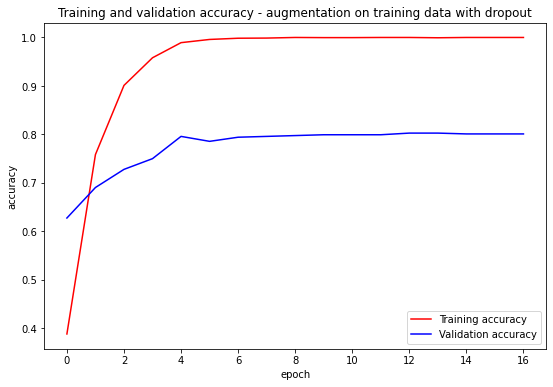

In [32]:
# dernière couche 'mixed5', dernière couche gelée 'mixed3'
# 20 epochs
# Exactitude données de test accuracy:   0.78
import matplotlib.pyplot as plt
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']
epochs = range(len(acc))
golden_number = 1.618
height = 6
length = int(golden_number * height)
plt.figure(figsize=(length,height))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy - augmentation on training data with dropout')
plt.legend(loc=0)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()


In [41]:
# dernière couche 'mixed10', dernière couche gelée 'mixed10'
# 20 epochs
# Test accuracy : 0.5871559381484985

In [42]:
erreur, exactitude = transfer_model.evaluate(normalized_test_dataset)
print("Exactitude données de test: %0.2f" % exactitude)

7/7 [==============================] - 0s 22ms/step - loss: 1.0550 - accuracy: 0.7615
Exactitude données de test: 0.76


In [43]:
predictions = transfer_model.predict(normalized_test_dataset)
predictions_index = np.argmax(predictions, axis=1)
predictions_index = [(etiquette+1) for etiquette in predictions_index]
print(predictions_index)

[16, 12, 5, 3, 3, 17, 9, 15, 1, 12, 18, 10, 8, 4, 12, 7, 19, 16, 3, 3, 8, 8, 10, 5, 15, 16, 3, 4, 10, 10, 3, 12, 18, 12, 16, 6, 18, 17, 3, 6, 15, 17, 3, 10, 13, 19, 15, 3, 9, 15, 1, 6, 6, 18, 18, 9, 9, 15, 3, 6, 2, 12, 3, 20, 19, 1, 16, 20, 14, 17, 5, 10, 6, 12, 3, 3, 6, 19, 12, 17, 1, 1, 10, 19, 8, 12, 2, 14, 12, 20, 9, 12, 4, 4, 19, 3, 16, 5, 10, 9, 10, 19, 12, 7, 2, 8, 11, 5, 10, 11, 3, 17, 20, 3, 14, 10, 4, 3, 19, 3, 12, 14, 4, 9, 1, 9, 1, 10, 16, 8, 10, 6, 8, 6, 3, 18, 18, 8, 1, 3, 9, 19, 19, 5, 8, 6, 9, 14, 2, 12, 3, 1, 18, 3, 15, 20, 12, 7, 6, 4, 16, 4, 9, 3, 12, 9, 19, 3, 20, 6, 8, 1, 14, 3, 17, 4, 2, 2, 11, 11, 3, 14, 5, 12, 16, 20, 16, 11, 17, 3, 18, 19, 20, 15, 12, 2, 3, 3, 9, 3, 8, 15, 19, 14, 4, 11, 6, 6, 8, 3, 9, 8, 15, 1, 7, 3, 4, 3]


In [44]:
vraies_etiquettes_index = list(np.concatenate([etiquette for image, etiquette in normalized_test_dataset], axis=0))
vraies_etiquettes_index = [(etiquette+1) for etiquette in vraies_etiquettes_index]
print(vraies_etiquettes_index)


[16, 12, 5, 3, 3, 6, 9, 15, 1, 12, 13, 10, 18, 6, 12, 7, 19, 9, 3, 3, 8, 8, 10, 5, 15, 16, 3, 4, 10, 10, 11, 12, 18, 12, 16, 6, 18, 17, 3, 5, 15, 9, 9, 13, 9, 19, 15, 3, 9, 15, 1, 6, 6, 18, 18, 10, 13, 3, 16, 17, 2, 12, 3, 20, 19, 1, 16, 20, 14, 17, 5, 10, 6, 7, 18, 3, 6, 19, 12, 17, 1, 1, 10, 11, 8, 6, 19, 14, 12, 20, 8, 7, 4, 4, 8, 3, 16, 5, 10, 9, 10, 19, 12, 7, 2, 8, 11, 5, 10, 11, 9, 12, 20, 3, 14, 10, 4, 3, 5, 3, 12, 20, 4, 9, 1, 9, 1, 10, 15, 8, 10, 16, 8, 6, 9, 17, 18, 9, 1, 16, 9, 19, 19, 5, 8, 6, 13, 14, 2, 5, 3, 2, 18, 15, 15, 20, 12, 6, 6, 4, 7, 4, 9, 3, 12, 8, 1, 3, 20, 6, 9, 12, 14, 8, 17, 4, 2, 2, 11, 11, 15, 14, 5, 12, 3, 20, 13, 11, 17, 16, 18, 19, 20, 15, 12, 2, 3, 3, 9, 3, 8, 15, 8, 14, 4, 11, 6, 6, 8, 3, 9, 11, 15, 1, 7, 15, 4, 3]


In [45]:
from sklearn import metrics
score = metrics.accuracy_score(vraies_etiquettes_index, predictions_index)
print("Exactitude:   %0.2f" % score)

Exactitude:   0.76


Text(0.5, 1.0, 'Matrice de confusion')

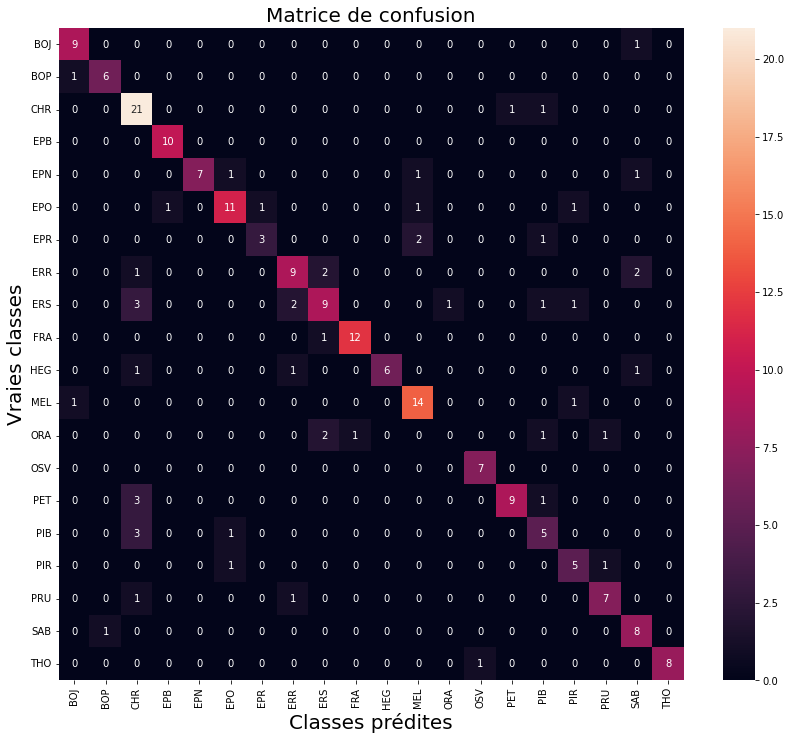

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix

y_true=np.argmax(vraies_etiquettes_index, axis=-1)
y_true= vraies_etiquettes_index
y_pred = predictions_index
cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
class_names = list(id_classes)

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(14, 12))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Classes prédites', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('Vraies classes', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Matrice de confusion', fontsize=20)


Matrice de confusion non normalisée


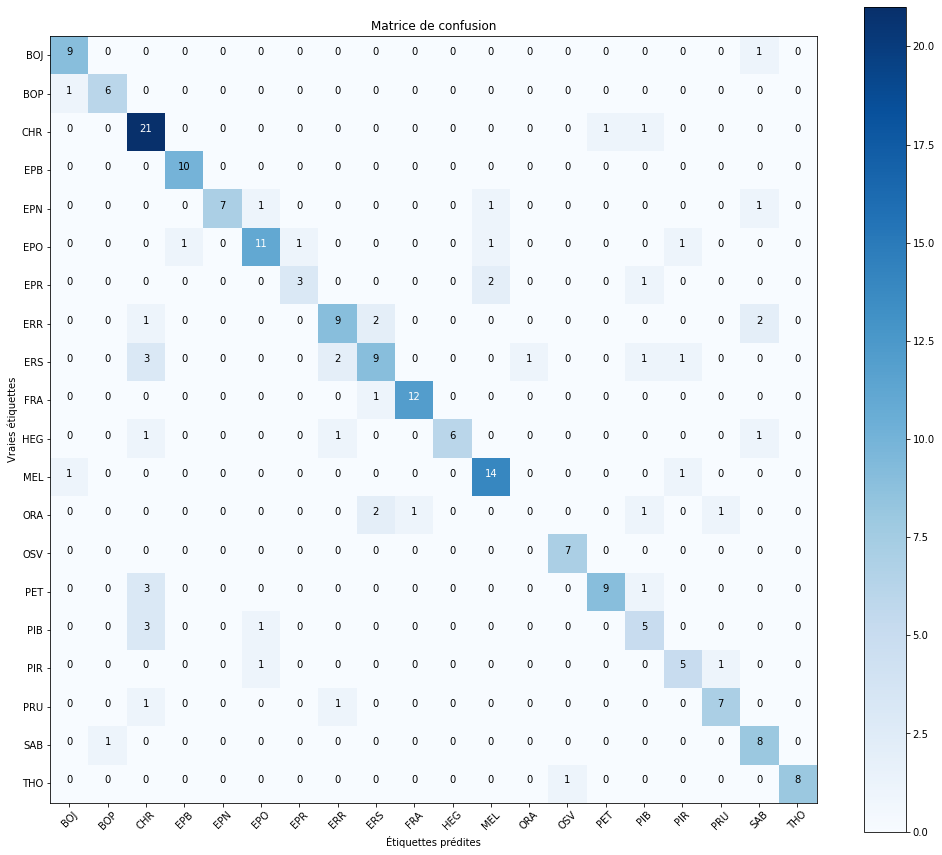

In [39]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matrice de confusion',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(14,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion non normalisée')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Vraies étiquettes')
    plt.xlabel('Étiquettes prédites')

cm = metrics.confusion_matrix(vraies_etiquettes_index, predictions_index)
plot_confusion_matrix(cm, classes=class_names)

In [40]:
print("Fin de l'exécution du carnet IPython")

Fin de l'exécution du carnet IPython
